# Lab 12-4 many to many variable bidirectional
### simple pos-tagger training 
* many to many
* variable input sequence length
* bi-directional

In [3]:
# setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
%matplotlib inline

print(tf.__version__)

2.1.0


### Prepairing dataset

In [4]:
# example data
sentences = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
pos = [['pronoun', 'verb', 'adjective'],
     ['noun', 'verb', 'adverb', 'adjective'],
     ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
     ['noun', 'verb', 'adverb', 'adjective', 'verb']]

### Preprocessing dataset

In [5]:
# creating a token dictionary for word
word_list = sum(sentences, [])
word_list = sorted(set(word_list))
word_list = ['<pad>'] + word_list
word2idx = {word : idx for idx, word in enumerate(word_list)}
idx2word = {idx : word for idx, word in enumerate(word_list)}

print(word2idx)
print(idx2word)
print(len(idx2word))

{'<pad>': 0, 'I': 1, 'a': 2, 'changing': 3, 'deep': 4, 'difficult': 5, 'fast': 6, 'feel': 7, 'for': 8, 'framework': 9, 'hungry': 10, 'is': 11, 'learning': 12, 'tensorflow': 13, 'very': 14}
{0: '<pad>', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}
15


In [6]:
# creating a token dictionary for part of speech
pos_list = sum(pos, [])
pos_list = sorted(set(pos_list))
pos_list = ['<pad>'] + pos_list
pos2idx = {pos : idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx : pos for idx, pos in enumerate(pos_list)}

print(pos2idx)
print(idx2pos)
print(len(pos2idx))

{'<pad>': 0, 'adjective': 1, 'adverb': 2, 'determiner': 3, 'noun': 4, 'preposition': 5, 'pronoun': 6, 'verb': 7}
{0: '<pad>', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}
8


In [7]:
# converting sequence of tokens to sequence of indices
max_sequence = 10
x_data = list(map(lambda sentence : [word2idx.get(token) for token in sentence], sentences))
y_data = list(map(lambda sentence : [pos2idx.get(token) for token in sentence], pos))

# padding the sequence of indices
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence, padding='post')
x_data_mask = ((x_data != 0) * 1).astype(np.float32)
x_data_len = list(map(lambda sentence : len(sentence), sentences))

y_data = pad_sequences(sequences = y_data, maxlen = max_sequence, padding='post')

# checking data
print(x_data, x_data_len)
print(x_data_mask)
print(y_data)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]] [3, 4, 7, 5]
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


### Creating model

In [8]:
# creating bidirectional rnn for "many to many" sequence tagging
num_classes = len(pos2idx)
hidden_dim = 10

input_dim = len(word2idx)
output_dim = len(word2idx)
one_hot = np.eye(len(word2idx))

model = Sequential()
model.add(layers.InputLayer(input_shape=(max_sequence,)))
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True,
                                 trainable=False, input_length=max_sequence,
                                 embeddings_initializer=keras.initializers.Constant(one_hot)))
model.add(layers.Bidirectional(keras.layers.SimpleRNN(units=hidden_dim, return_sequences=True)))
model.add(layers.TimeDistributed(keras.layers.Dense(units=num_classes)))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 15)            225       
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 20)            520       
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 8)             168       
Total params: 913
Trainable params: 688
Non-trainable params: 225
_________________________________________________________________


### Training model

In [10]:
# creating loss function
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
    valid_time_step = tf.cast(x_len,dtype=tf.float32)
    sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True) * masking    
    sequence_loss = tf.reduce_sum(sequence_loss, axis=-1) / valid_time_step
    sequence_loss = tf.reduce_mean(sequence_loss)
    return sequence_loss

# creating and optimizer
lr = 0.1
epochs = 30
batch_size = 2 
opt = tf.keras.optimizers.Adam(learning_rate = lr)

In [11]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, x_data_len))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size = 2)

print(tr_dataset)

<BatchDataset shapes: ((None, 10), (None, 10), (None,)), types: (tf.int32, tf.int32, tf.int32)>


In [12]:
# training
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb, x_mb_len in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb, x_len=x_mb_len, max_sequence=max_sequence)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)
    
    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

epoch :   5, tr_loss : 0.014
epoch :  10, tr_loss : 0.001
epoch :  15, tr_loss : 0.000
epoch :  20, tr_loss : 0.000
epoch :  25, tr_loss : 0.000
epoch :  30, tr_loss : 0.000


### Checking performance

In [13]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1) * x_data_mask

pprint(list(map(lambda row : [idx2pos.get(elm) for elm in row],yhat.astype(np.int32).tolist())), width = 120)
pprint(pos)

[['pronoun', 'verb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


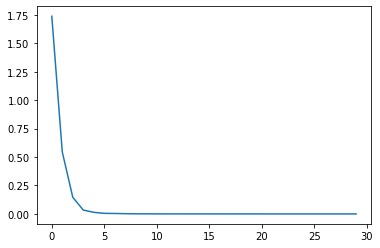

In [14]:
plt.plot(tr_loss_hist)

# Lab 12-5 sequence to sequence (Keras + eager version)

### simple neural machine translation training

* sequence to sequence
  
### Reference
* [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

from matplotlib import font_manager, rc

rc('font', family='AppleGothic') #for mac

import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

from pprint import pprint
import numpy as np
import os

print(tf.__version__)

2.1.0


In [2]:
sources = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
targets = [['나는', '배가', '고프다'],
           ['텐서플로우는', '매우', '어렵다'],
           ['텐서플로우는', '딥러닝을', '위한', '프레임워크이다'],
           ['텐서플로우는', '매우', '빠르게', '변화한다']]

In [3]:
# vocabulary for sources
s_vocab = list(set(sum(sources, [])))
s_vocab.sort()
s_vocab = ['<pad>'] + s_vocab
source2idx = {word : idx for idx, word in enumerate(s_vocab)}
idx2source = {idx : word for idx, word in enumerate(s_vocab)}

pprint(source2idx)

{'<pad>': 0,
 'I': 1,
 'a': 2,
 'changing': 3,
 'deep': 4,
 'difficult': 5,
 'fast': 6,
 'feel': 7,
 'for': 8,
 'framework': 9,
 'hungry': 10,
 'is': 11,
 'learning': 12,
 'tensorflow': 13,
 'very': 14}


In [4]:
# vocabulary for targets
t_vocab = list(set(sum(targets, [])))
t_vocab.sort()
t_vocab = ['<pad>', '<bos>', '<eos>'] + t_vocab
target2idx = {word : idx for idx, word in enumerate(t_vocab)}
idx2target = {idx : word for idx, word in enumerate(t_vocab)}

pprint(target2idx)

{'<bos>': 1,
 '<eos>': 2,
 '<pad>': 0,
 '고프다': 3,
 '나는': 4,
 '딥러닝을': 5,
 '매우': 6,
 '배가': 7,
 '변화한다': 8,
 '빠르게': 9,
 '어렵다': 10,
 '위한': 11,
 '텐서플로우는': 12,
 '프레임워크이다': 13}


In [5]:
def preprocess(sequences, max_len, dic, mode = 'source'):
    assert mode in ['source', 'target'], 'source와 target 중에 선택해주세요.'
    
    if mode == 'source':
        # preprocessing for source (encoder)
        s_input = list(map(lambda sentence : [dic.get(token) for token in sentence], sequences))
        s_len = list(map(lambda sentence : len(sentence), s_input))
        s_input = pad_sequences(sequences = s_input, maxlen = max_len, padding = 'post', truncating = 'post')
        return s_len, s_input
    
    elif mode == 'target':
        # preprocessing for target (decoder)
        # input
        t_input = list(map(lambda sentence : ['<bos>'] + sentence + ['<eos>'], sequences))
        t_input = list(map(lambda sentence : [dic.get(token) for token in sentence], t_input))
        t_len = list(map(lambda sentence : len(sentence), t_input))
        t_input = pad_sequences(sequences = t_input, maxlen = max_len, padding = 'post', truncating = 'post')
        
        # output
        t_output = list(map(lambda sentence : sentence + ['<eos>'], sequences))
        t_output = list(map(lambda sentence : [dic.get(token) for token in sentence], t_output))
        t_output = pad_sequences(sequences = t_output, maxlen = max_len, padding = 'post', truncating = 'post')
        
        return t_len, t_input, t_output

In [6]:
# preprocessing for source
s_max_len = 10
s_len, s_input = preprocess(sequences = sources,
                            max_len = s_max_len, dic = source2idx, mode = 'source')
print(s_len, s_input)

[3, 4, 7, 5] [[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]


In [7]:
# preprocessing for target
t_max_len = 12
t_len, t_input, t_output = preprocess(sequences = targets,
                                      max_len = t_max_len, dic = target2idx, mode = 'target')
print(t_len, t_input, t_output)

[5, 5, 6, 6] [[ 1  4  7  3  2  0  0  0  0  0  0  0]
 [ 1 12  6 10  2  0  0  0  0  0  0  0]
 [ 1 12  5 11 13  2  0  0  0  0  0  0]
 [ 1 12  6  9  8  2  0  0  0  0  0  0]] [[ 4  7  3  2  0  0  0  0  0  0  0  0]
 [12  6 10  2  0  0  0  0  0  0  0  0]
 [12  5 11 13  2  0  0  0  0  0  0  0]
 [12  6  9  8  2  0  0  0  0  0  0  0]]


# hyper-param

In [8]:
# hyper-parameters
epochs = 200
batch_size = 4
learning_rate = .005
total_step = epochs / batch_size
buffer_size = 100
n_batch = buffer_size//batch_size
embedding_dim = 32
units = 32

# input
data = tf.data.Dataset.from_tensor_slices((s_len, s_input, t_len, t_input, t_output))
data = data.shuffle(buffer_size = buffer_size)
data = data.batch(batch_size = batch_size)
# s_mb_len, s_mb_input, t_mb_len, t_mb_input, t_mb_output = iterator.get_next()

In [9]:
def gru(units):
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_initializer='glorot_uniform')

In [10]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
                
    def call(self, x, hidden, enc_output):
        
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [12]:
encoder = Encoder(len(source2idx), embedding_dim, units, batch_size)
decoder = Decoder(len(target2idx), embedding_dim, units, batch_size)

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    
#     print("real: {}".format(real))
#     print("pred: {}".format(pred))
#     print("mask: {}".format(mask))
#     print("loss: {}".format(tf.reduce_mean(loss_)))
    
    return tf.reduce_mean(loss_)

# creating optimizer
optimizer = tf.keras.optimizers.Adam()

# creating check point (Object-based saving)
checkpoint_dir = './data_out/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                encoder=encoder,
                                decoder=decoder)

# create writer for tensorboard
#summary_writer = tf.summary.create_file_writer(logdir=checkpoint_dir)

In [13]:
for epoch in range(epochs):
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for i, (s_len, s_input, t_len, t_input, t_output) in enumerate(data):
        loss = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(s_input, hidden)

            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([target2idx['<bos>']] * batch_size, 1)
            
            #Teacher Forcing: feeding the target as the next input
            for t in range(1, t_input.shape[1]):
                
                predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(t_input[:, t], predictions)
            
                dec_input = tf.expand_dims(t_input[:, t], 1) #using teacher forcing
                
        batch_loss = (loss / int(t_input.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradient = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradient, variables))
        
    if epoch % 10 == 0:
        #save model every 10 epoch
        print('Epoch {} Loss {:.4f} Batch Loss {:.4f}'.format(epoch,
                                            total_loss / n_batch,
                                            batch_loss.numpy()))
        checkpoint.save(file_prefix = checkpoint_prefix)

Epoch 0 Loss 0.0397 Batch Loss 0.9913
Epoch 10 Loss 0.0386 Batch Loss 0.9657
Epoch 20 Loss 0.0372 Batch Loss 0.9303
Epoch 30 Loss 0.0347 Batch Loss 0.8685
Epoch 40 Loss 0.0311 Batch Loss 0.7785
Epoch 50 Loss 0.0276 Batch Loss 0.6899
Epoch 60 Loss 0.0242 Batch Loss 0.6041
Epoch 70 Loss 0.0211 Batch Loss 0.5279
Epoch 80 Loss 0.0184 Batch Loss 0.4607
Epoch 90 Loss 0.0160 Batch Loss 0.4001
Epoch 100 Loss 0.0137 Batch Loss 0.3433
Epoch 110 Loss 0.0116 Batch Loss 0.2911
Epoch 120 Loss 0.0098 Batch Loss 0.2448
Epoch 130 Loss 0.0082 Batch Loss 0.2058
Epoch 140 Loss 0.0070 Batch Loss 0.1741
Epoch 150 Loss 0.0060 Batch Loss 0.1489
Epoch 160 Loss 0.0052 Batch Loss 0.1296
Epoch 170 Loss 0.0046 Batch Loss 0.1157
Epoch 180 Loss 0.0042 Batch Loss 0.1061
Epoch 190 Loss 0.0040 Batch Loss 0.0993


In [14]:
#restore checkpoint

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [15]:
sentence = 'I feel hungry'

In [16]:
def prediction(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    
    inputs = [inp_lang[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
        
    result = ''
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
        
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang['<bos>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_out)
        
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += idx2target[predicted_id] + ' '

        if idx2target.get(predicted_id) == '<eos>':
            return result, sentence
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)    
    
    return result, sentence
    
result, output_sentence = prediction(sentence, encoder, decoder, source2idx, target2idx, s_max_len, t_max_len)

print(sentence)
print(result)

I feel hungry
나는 배가 고프다 <eos> 
